# Inferência com modelos de Visão e Linguagem

Veremos como criar uma conversa com um VLM, e detalhes de como os dados são enviados e retornados pelo modelo.

In [1]:
import torch
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    Qwen2_5_VLForConditionalGeneration,
)

# A imagem será redimensionada para aproximadamente o tamanho de 16*28 x 16*28 = 448 x 448 pixels
max_pixels = 256*28*28  

name = "Qwen/Qwen2.5-VL-7B-Instruct"

quantization_config = BitsAndBytesConfig(load_in_4bit=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    name, 
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=quantization_config,
    ) 
processor = AutoProcessor.from_pretrained(name, max_pixels=max_pixels, use_fast=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
# Template para o chat. Note a a presença do comando 
# "if content['type'] == 'image' ... <|vision_start|><|image_pad|><|vision_end|>"
# Esse comando substitui o tipo "image" por tokens que indicam a presença de uma imagem
print(processor.chat_template)

{% set image_count = namespace(value=0) %}{% set video_count = namespace(value=0) %}{% for message in messages %}{% if loop.first and message['role'] != 'system' %}<|im_start|>system
You are a helpful assistant.<|im_end|>
{% endif %}<|im_start|>{{ message['role'] }}
{% if message['content'] is string %}{{ message['content'] }}<|im_end|>
{% else %}{% for content in message['content'] %}{% if content['type'] == 'image' or 'image' in content or 'image_url' in content %}{% set image_count.value = image_count.value + 1 %}{% if add_vision_id %}Picture {{ image_count.value }}: {% endif %}<|vision_start|><|image_pad|><|vision_end|>{% elif content['type'] == 'video' or 'video' in content %}{% set video_count.value = video_count.value + 1 %}{% if add_vision_id %}Video {{ video_count.value }}: {% endif %}<|vision_start|><|video_pad|><|vision_end|>{% elif 'text' in content %}{{ content['text'] }}{% endif %}{% endfor %}<|im_end|>
{% endif %}{% endfor %}{% if add_generation_prompt %}<|im_start|>assi

In [3]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image"  # Indica que uma imagem será inserida nesta posição
            },
            {
                "type": "text", 
                "text": "Describe this image."
            },
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
text

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

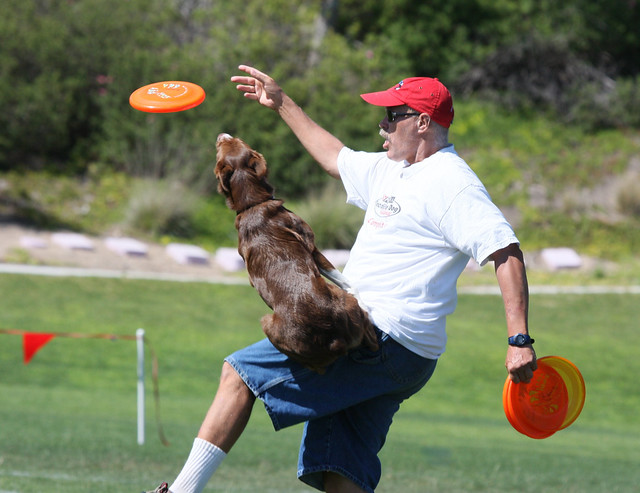

In [4]:
# Leitura da imagem
from PIL import Image
img = Image.open("../data/man_with_dog.jpg")
img

In [5]:
inputs = processor(
    text=[text],
    images=[img],
    videos=None,
    padding=True,
    return_tensors="pt",
)

inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

Os elementos de `inputs` são:

1. input_ids: tokens representando o texto e imagem de entrada
2. pixel_values: a imagem de entrada do modelo, redimensionada e normalizada em relação à imagem original. Os pixels também são rearranjados de acordo com os patches criados
3. image_grid_thw: tupla indicando o número de patches gerados ao longo das linhas e colunas da imagem

In [11]:
inputs["input_ids"][0, :100]

tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
        151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655])

In [12]:
# Texto de entrada do modelo. num_patches/4 tokens <|image_pad|> são adicionados ao texto. 
# Esses tokens serão substituídos pelas representações dos patches da imagem gerados pelo 
# codificador de imagem ViT. O fator /4 é porque 2x2 tokens adjacentes são unidos por um MLP após 
# o modelo ViT
print(processor.batch_decode(inputs["input_ids"])[0])

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|

In [14]:
def get_img_shape(image_grid_thw, processor):
    """Tamanho da imagem que foi de fato processada pelo modelo."""
    
    grid_t, grid_h, grid_w = image_grid_thw
    ps = processor.image_processor.patch_size
    return grid_h.item()*ps, grid_w.item()*ps

input_shape = get_img_shape(inputs["image_grid_thw"][0], processor)
input_shape

(392, 504)

In [15]:
print(inputs["pixel_values"].shape)

# O tamanho de `pixel_values` é dado por (número de patches, tamanho de cada patch)
# O tamanho de cada patch é dado por (2 * número de canais * altura * largura / num_patches). Há
# um fator de 2 porque a imagem é replicada pois o modelo foi treinado recebendo sempre no mínimo
# 2 imagens (para processamento de vídeo).
num_patches = inputs["image_grid_thw"].prod()
tam_patches = 2*3*input_shape[0]*input_shape[1]//num_patches
(num_patches, tam_patches)

torch.Size([1008, 1176])


(tensor(1008), tensor(1176))

In [19]:
generated_ids = model.generate(**inputs.to("cuda"), max_new_tokens=128)
num_input_tokens = len(inputs["input_ids"][0])
output_text = processor.batch_decode(
   generated_ids[:, num_input_tokens:], skip_special_tokens=True
)
print(output_text)

['The image shows a man and a dog playing with a frisbee in an outdoor setting, likely a park or a field. The man is wearing a white t-shirt, blue shorts, a red cap, sunglasses, and a wristwatch. He appears to be mid-action, possibly throwing the frisbee. The dog, which looks like a brown Labrador Retriever, is leaping into the air to catch the frisbee. The background features green grass, some trees, and a few scattered objects that might be part of a sports field or park setup. The overall scene suggests a fun and active moment between the man and']


### Conversa sobre a imagem

Os códigos acima estão implementados na classe Chat do arquivo chat_utils.py. A classe também possui o método `add_to_chat` que permite adicionar novas mensagens ao histórico de mensagens, incluindo a resposta do modelo.

In [4]:
from chat_utils import Chat

chat = Chat(model, processor)

img = Image.open("../data/man_with_dog.jpg")

output = chat.query_model("Is there a person in this image?", img)
output

'Yes, there is a person in the image. The person is wearing a white shirt and blue shorts, and they appear to be playing with a dog that is jumping up to catch a frisbee.'

In [5]:
chat.add_to_chat(output, role="assistant")

output = chat.query_model("Is the person young?")
print(output)

The image shows a person who appears to be an adult based on their physical features and posture. It's not possible to determine the exact age of the person from the image alone, but it does not appear to be a young child.


In [7]:
chat.add_to_chat(output, role="assistant")

output = chat.query_model("Where are they?")
print(output)

The image depicts a scene where a person and a dog are engaged in an activity, possibly playing fetch in an outdoor setting. Based on the visible elements such as the grass, trees, and the open space, it seems to be a park or a similar recreational area. However, without more specific landmarks or context, it's not possible to pinpoint the exact location. The activity itself is common in many parks around the world.
